This script demonstrates the use of FLAML AutoML to train a baseline regression model using different fraction of the fine-tuning training dataset. The baseline model's predictions are then compared with the fine-tuned model's results on the MEGAPOLI Marine test dataset.

Key steps include:

1. **Data Preprocessing**:
   - Cleaning and preparing the training dataset by removing missing values.
   - Extracting features and target variables for training and testing.

2. **Model Training with AutoML**:
   - Setting a time budget and configuring model evaluation using cross-validation.
   - Automatically selecting the best model and hyperparameters from a list of estimators.

3. **Evaluation**:
   - Using the trained AutoML model to make predictions on the test dataset.
   - Calculating evaluation metrics: R², RMSE, MAE, and MAPE.

4. **Visualization**:
   - Plotting actual vs. predicted values over time for better interpretability.

5. **Comparison**:
   - The trained baseline model serves as a reference for comparing its performance against 
     a fine-tuned model.

This process enables efficient model benchmarking and evaluation in aerosol research applications.

In [2]:
import pandas as pd
import numpy as np
import json
import time
from flaml import AutoML
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import joblib
import sys
import matplotlib.pyplot as plt


In [ ]:
# Number of parallel jobs (e.g., for model training)
n_jobs = int(8)

# Load the training dataset
df_train = pd.read_csv('../Data/MEGAPOLI_data/MEGAPOLI_Marine_train_5%.csv')

# Drop rows with missing values to ensure clean data
df_train = df_train.dropna()

input_list = ['O3 (ppb)', 'CO (ppb)', 'NO (ppb)', 'NOx (ppb)',
        'ETH (ppb)', 'TOL(ppb)', 'XYL (ppb)', 'ALD2 (ppb)',
       'AONE (ppb)', 'PAR (ppb)', 'OLET (ppb)', 'Temperature(K)', 'RH',
       'BC (ug/m3)', 'OA (ug/m3)', 'NH4 (ug/m3)', 'NO3 (ug/m3)', 'SO4 (ug/m3)']

# Set log file, model file, and output file names
log_file_name = "AutoML_5%Data"+".log"
model_file_name = "AutoML_5%Data" + ".pkl"
output_file = "AutoML_5%Data"+".csv"

# Extract chi value for training
output_list = df_train.columns[23]

# Extract input features and target variable for training
X_train = df_train[input_list]
y_train = df_train[output_list]



In [9]:
# setup for automl
automl = AutoML()

# Set the time budget for AutoML (in seconds)
time_budget =1

# Specify automl goal and constraint
automl_settings = {
    "time_budget": time_budget,  # in seconds
    "metric": 'mse',   # Time budget for the entire AutoML process
    "task": 'regression',   # Task type (regression in this case)
    "eval_method" : "cv",   # Cross-validation for model evaluation
    "n_splits":5,           # Number of folds in cross-validation
    "estimator_list": [
        "lgbm",
        "xgboost",
        "rf",
        "extra_tree",
    ],
    "n_jobs": n_jobs,
    "log_file_name": log_file_name,
}

# Train the AutoML model with labeled input data
automl.fit(X_train=X_train, y_train=y_train,
           **automl_settings)

# Print the best model selected by AutoML
print(automl.model.estimator)

# Save the best model selected by AutoML
best_model = automl.model.estimator
joblib.dump(best_model, model_file_name)


[flaml.automl.logger: 11-19 00:20:28] {1680} INFO - task = regression
[flaml.automl.logger: 11-19 00:20:28] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 11-19 00:20:28] {1789} INFO - Minimizing error metric: mse
[flaml.automl.logger: 11-19 00:20:28] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'rf', 'extra_tree']


[flaml.automl.logger: 11-19 00:20:28] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 11-19 00:20:28] {2345} INFO - Estimated sufficient time budget=258s. Estimated necessary time budget=0s.
[flaml.automl.logger: 11-19 00:20:28] {2392} INFO -  at 0.1s,	estimator lgbm's best error=0.0006,	best estimator lgbm's best error=0.0006
[flaml.automl.logger: 11-19 00:20:28] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 11-19 00:20:28] {2392} INFO -  at 0.1s,	estimator lgbm's best error=0.0006,	best estimator lgbm's best error=0.0006
[flaml.automl.logger: 11-19 00:20:28] {2219} INFO - iteration 2, current learner lgbm
[flaml.automl.logger: 11-19 00:20:28] {2392} INFO -  at 0.1s,	estimator lgbm's best error=0.0006,	best estimator lgbm's best error=0.0006
[flaml.automl.logger: 11-19 00:20:28] {2219} INFO - iteration 3, current learner lgbm
[flaml.automl.logger: 11-19 00:20:28] {2392} INFO -  at 0.1s,	estimator lgbm's best error=0.0006,	best estimator lg

['AutoML_5%Data.pkl']

In [7]:
def calculate_metrics_and_plot(y_true, y_pred, time_column):
    """
    Calculate evaluation metrics and plot actual vs. predicted values over time.

    Parameters:
    - y_true: Actual target values
    - y_pred: Predicted target values
    - time_column: Corresponding time column for the x-axis

    Returns:
    - Tuple of calculated metrics (R2, RMSE, MAE, MAPE)
    """

    # Calculate evaluation metrics
    r2 = r2_score(y_true, y_pred)  # R-squared
    rmse = mean_squared_error(y_true, y_pred, squared=False)  # Root Mean Squared Error
    mae = mean_absolute_error(y_true, y_pred)  # Mean Absolute Error
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error

    # Print the calculated metrics
    print(f'R2: {r2}')
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')
    print(f'MAPE: {mape}')

    # Plot actual vs. predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(time_column, y_true, label='Actual', color='blue')  # Actual values in blue
    plt.plot(time_column, y_pred, label='Predicted', color='red')  # Predicted values in red
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('Actual vs Predicted')
    plt.legend()
    plt.show()

    # Return the calculated metrics
    return r2, rmse, mae, mape


R2: -1.203581034003319
RMSE: 0.0977577447300068
MAE: 0.0810131211066026
MAPE: 15.750085359776985


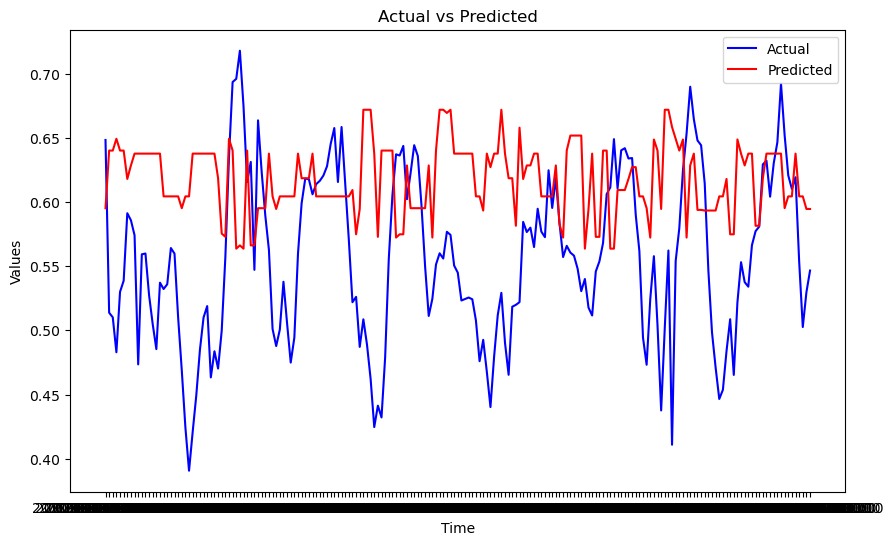

(-1.203581034003319,
 0.0977577447300068,
 0.0810131211066026,
 15.750085359776985)

In [ ]:
automl = joblib.load(model_file_name)


# Load the test dataset
df_test = pd.read_csv('../Data/MEGAPOLI_data/MEGAPOLI_Marine_test_50%.csv')

# Extract features and target variable from the test dataset
X_test = df_test[input_list]
y_test = df_test[output_list]

# Make predictions using the AutoML model
y_test_pred = automl.predict(X_test)


# Save y_true and y_pred as a DataFrame
results_df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_test_pred
})
results_df.to_csv('/Data/Fine_tuned_Results_different_data_size/AutoML_5%Data.csv', index=False)

calculate_metrics_and_plot(y_test, y_test_pred, df_test['Time'])